## Movie Recommendation Predict

Recommender systems play a vital role in today's technology-driven world by helping individuals make informed choices about the content they engage with daily. This is particularly true for movie recommendations, where intelligent algorithms can assist viewers in discovering great titles from a vast selection. Have you ever wondered how streaming platforms like Netflix, Amazon Prime, Showmax, and Disney seem to know what to recommend to you? In this challenge we will walk you through our movie recommender.

<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading The Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>


   <a href=#six>6.1 Kaggle Submission CSV File</a>
   

<a href=#eight>7. Conclusion</a>

 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>

In [1]:
pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#firstly to import important libraries
import pandas as pd
import numpy as np
import io
#for plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
#for proceccing the data
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from surprise import SVD
from surprise.model_selection import cross_validate
#to display codes without warning
import warnings
warnings.filterwarnings('ignore')

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

There are a few dataframes that are to be imported, so simply importing the data for now and having the information within displayed a little down the line will help keep the notebook more aestheticaly pleasing.

In [4]:
genome_scores=pd.read_csv("/genome_scores.csv")
genome_tags=pd.read_csv("/genome_tags.csv")
imdb_data= pd.read_csv("/imdb_data.csv")
links= pd.read_csv("/links.csv")
movies= pd.read_csv("/movies.csv")
tags= pd.read_csv("/tags.csv")
df_test=pd.read_csv("/test.csv")
df_train= pd.read_csv("/train.csv")

<a id="three"></a>
## 3. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

Having imported all of the data, it becomes clear that there is a lot of data to go through. This might prove dificult to provide an acurate analysis of the data. So to go through it with more ease, a basic EDA function was created to help show the basic information of each dataframe. this EDA function shows if the dataset has: missing values and also the position of the missing values, outliers and their position as well, check the data types, and lastly the correlation of the data.

In [5]:
def EDA(data):
    """Perform exploratory data analysis on a given dataset.
    Args:
      data (pandas.DataFrame): The dataset to analyze.
    """
    from IPython.display import display
    display(data.head())
    # Check for missing values
    if data.isnull().values.any():
        # Find the number of missing values for each column
        missing_counts = data.isnull().sum()
        # Select only the columns with missing values
        missing_columns = missing_counts[missing_counts > 0]
        print(f"Missing values found in columns: {missing_columns}")
    else:
        print("No missing values found")

    # Check for outliers
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    if outliers.empty:
        print("No outliers found")
    else:
        print(f"Outliers found at positions: {outliers.index}")

    # Check data types
    data_types = data.dtypes
    print(f"Data types: {data_types}")

    # Check correlations
    correlations = data.corr()
    display(correlations)

With EDA function above, now it is easier going through each dataframe and perfom simple data exploration. Below this step is completed swiftly

In [6]:
#fitting the EDA function to the test data as well as the train data
EDA(df_train)

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


No missing values found
Outliers found at positions: RangeIndex(start=0, stop=10000038, step=1)
Data types: userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object


,userId,movieId,rating,timestamp
userId,1.000000,-0.004270,0.002202,-0.001347
movieId,-0.004270,1.000000,-0.008940,0.520786
rating,0.002202,-0.008940,1.000000,0.010301
timestamp,-0.001347,0.520786,0.010301,1.000000


In [7]:
EDA(df_test)

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


No missing values found
Outliers found at positions: RangeIndex(start=0, stop=5000019, step=1)
Data types: userId     int64
movieId    int64
dtype: object


,userId,movieId
userId,1.000000,-0.004401
movieId,-0.004401,1.000000


In [8]:
#firstly the genome score
EDA(genome_scores)

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


No missing values found
Outliers found at positions: RangeIndex(start=0, stop=15584448, step=1)
Data types: movieId        int64
tagId          int64
relevance    float64
dtype: object


,movieId,tagId,relevance
movieId,1.000000e+00,-1.390078e-13,0.015355
tagId,-1.390078e-13,1.000000e+00,0.017763
relevance,1.535521e-02,1.776320e-02,1.000000


In [9]:
#genome tags
EDA(genome_tags)

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


No missing values found
Outliers found at positions: RangeIndex(start=0, stop=1128, step=1)
Data types: tagId     int64
tag      object
dtype: object


,tagId
tagId,1.0


In [10]:
#for the imdb data
EDA(imdb_data)

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


Missing values found in columns: title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64
Outliers found at positions: RangeIndex(start=0, stop=27278, step=1)
Data types: movieId            int64
title_cast        object
director          object
runtime          float64
budget            object
plot_keywords     object
dtype: object


,movieId,runtime
movieId,1.00000,-0.13273
runtime,-0.13273,1.00000


In [11]:
#the movies dataframe
EDA(movies)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


No missing values found
Outliers found at positions: RangeIndex(start=0, stop=62423, step=1)
Data types: movieId     int64
title      object
genres     object
dtype: object


,movieId
movieId,1.0


In [12]:
#now the tags
EDA(tags)

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


Missing values found in columns: tag    16
dtype: int64
Outliers found at positions: RangeIndex(start=0, stop=1093360, step=1)
Data types: userId        int64
movieId       int64
tag          object
timestamp     int64
dtype: object


,userId,movieId,timestamp
userId,1.000000,-0.101326,-0.197582
movieId,-0.101326,1.000000,0.400216
timestamp,-0.197582,0.400216,1.000000


In [13]:
EDA(links)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


Missing values found in columns: tmdbId    107
dtype: int64
Outliers found at positions: RangeIndex(start=0, stop=62423, step=1)
Data types: movieId      int64
imdbId       int64
tmdbId     float64
dtype: object


,movieId,imdbId,tmdbId
movieId,1.000000,0.466805,0.581131
imdbId,0.466805,1.000000,0.820764
tmdbId,0.581131,0.820764,1.000000


From the above information, it becomes clear that the data contains a few columns missing values, with  missing values found in the 'imdb_data' in only four columns and as well on 'tags' and 'links' having missing value. As for the outliers, the data seems have quite a few outliers. This could be due to the diversity of the data, how the data was entered or a myriad of other reasons. It might prove more fruitful to display the data numerical data and see how much of the data is outlier prone. The data types seem to show that the prominent datatypes are intergers and objects with only 2 columns being float datatypes.

#### Checking the columns with null values
We will have to see how much of the columns from the data which were found to have nulls is missing and if these missing values can be fixed by filling them in anyway or if they have to be dropped later on in the data handling phase

In [14]:
#to check the percantage of missing data
director_nulls= imdb_data['director'].isnull().mean()
runtime_nulls= imdb_data['runtime'].isnull().mean()
tmdbId_nulls= links['tmdbId'].isnull().mean()
tag_nulls= tags['tag'].isnull().mean()
plot_keywords_nulls= imdb_data['plot_keywords'].isnull().mean()
budget_nulls= imdb_data['budget'].isnull().mean()
# print the percentage of missing data
print("Percentage of missing data in column 'director': {:.2f}%".format(director_nulls*100))
print("Percentage of missing data in column 'runtime': {:.2f}%".format(runtime_nulls*100))
print("Percentage of missing data in column 'budget': {:.2f}%".format(budget_nulls*100))
print("Percentage of missing data in column 'plot_keywords': {:.2f}%".format(plot_keywords_nulls*100))
print("Percentage of missing data in column 'tag': {:.2f}%".format(tag_nulls*100))
print("Percentage of missing data in column 'tmdbId': {:.2f}%".format(tmdbId_nulls*100))

Percentage of missing data in column 'director': 36.20%
Percentage of missing data in column 'runtime': 44.32%
Percentage of missing data in column 'budget': 71.02%
Percentage of missing data in column 'plot_keywords': 40.61%
Percentage of missing data in column 'tag': 0.00%
Percentage of missing data in column 'tmdbId': 0.17%


It would seem that a noticeable chunk of the columns with missing data actually has missing data, with an exception of the 'tag' and the 'tmdbId' column, as it seems the missing values are negligible. This can be seen visually below in the bar chart. This will be addressed in the data handling.

<Figure size 1080x720 with 0 Axes>

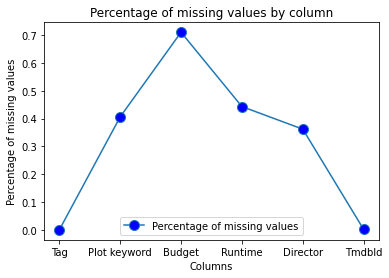

In [15]:
missing_data={'Tag': tag_nulls, 'Plot keyword': plot_keywords_nulls, 'Budget': budget_nulls,
              'Runtime': runtime_nulls, 'Director': director_nulls, 'TmdbId':tmdbId_nulls}
missing_data = pd.DataFrame(list(missing_data.items()),columns= ['Columns', 'Percentage of missing values'])
plt.figure(figsize=(15, 10))
missing_data.plot(kind='line',x='Columns',y='Percentage of missing values',  
                  marker='o', linestyle='-', markersize=10, markerfacecolor='blue')
plt.xlabel('Columns')
plt.ylabel('Percentage of missing values')
plt.title('Percentage of missing values by column')
plt.show()

For more visuals, one would perhaps want to see what relationships can be infered from the data sets or what relationships could be interesting to explore. This will require some creative thinking since some key columns such as budget and runtime are missing a significant amount of data. However below we can see the top 15 highest rated genres.

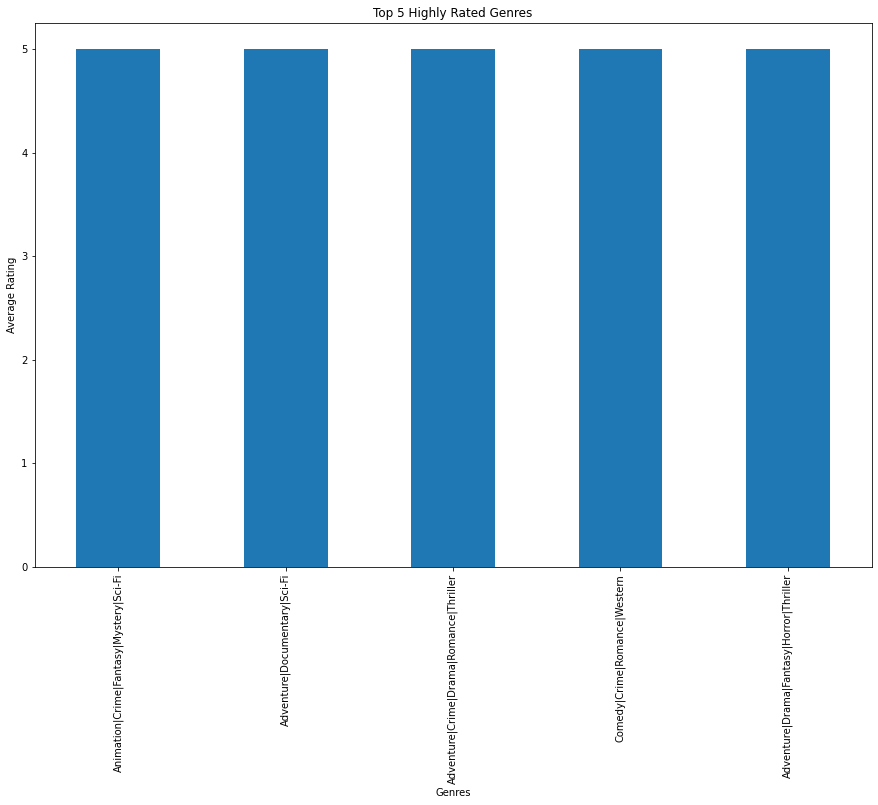

In [16]:
# merge data on movieId
merged_df = pd.merge(movies, df_train, on='movieId')
# group the data by genre and calculate the mean rating for each group
genre_ratings = merged_df.groupby('genres')['rating'].mean().sort_values(ascending=False)
# select the top 15 highly rated genres
top_genres = genre_ratings.head(5)
# create the bar chart
plt.figure(figsize=(15, 10))
top_genres.plot(kind='bar',xlabel='Genres', ylabel='Average Rating',title='Top 5 Highly Rated Genres')
plt.xticks(rotation=90)
plt.show()

This goes on to show that from some of the most popular genres crime and adventure are the two most highly rated genres. But overall genres such as comedy, drama, fantasy etc all have high ratings of 5.

another thing that can be shown is how the ratings are distributed throughout the dataset as shown below. this piechart shows the percentage of each rating, with the ratings labeled from 0.5 (the lowest) all the way to 5.0 (highest rating) all in intervals of 0.5

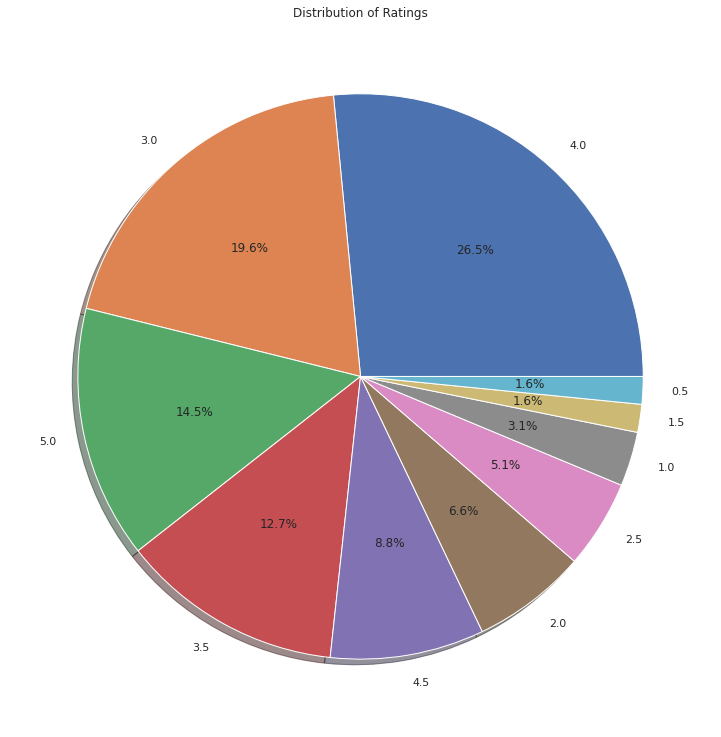

In [17]:
# Visualize the distribution of ratings
sns.set(rc={'figure.figsize':(27,13)})
rating_counts = df_train['rating'].value_counts()
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', shadow=True)
plt.title('Distribution of Ratings')
plt.show()

but the exploration of the data sets does not end there. When movies are being titled, there could be a method in which movie titles are chosen in way that could results in higher rating or better responses from the audiance. A word cloud can be used to show the most popular words in titles.

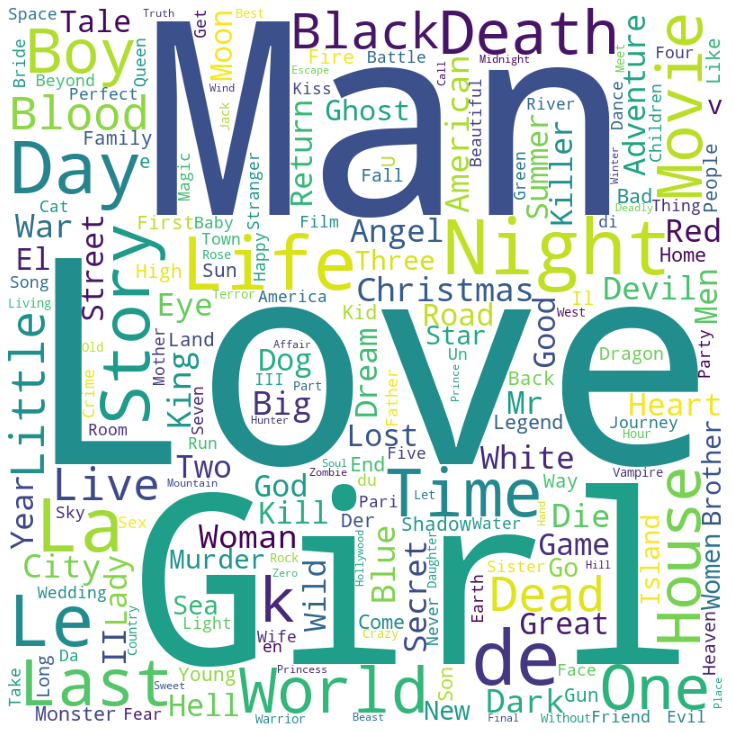

In [18]:
#create a set of english stopwords
stopwords = set(stopwords.words('english'))
#create a list of all the words in the 'title' column
words = ' '.join(movies['title'])
#create a wordcloud object
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(words)

# plot the wordcloud
plt.figure(figsize = (15, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

From the wordcloud it becomes apparent that words like Love, Man and Girl are largly popular when naming a movie. One could, at this point only speculate as to what role naming does to the popularity of a movie. Although it can be said that the name of the movie does play an important role in being as discriptive, eye catching and as relevant as possible so as to attract the intended target market.

With the exploration of the data done as extensively as possible. It is now time to move on to the Data Engineering phase.

<a id="four"></a>
## 4. Data Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

From the Exploratory Data Analysis, it was made clear that the columns from the imdb data are lacking a significant amount of information. In this phase of the project, it is important to drop those columns. But one thing that needs to be noted is that the aim of the project is to determine the ratings based on the data given. This leads to a lot of the data to be rendered useless, leading to a few dataframes suitable for our mission. 

A collaborative model would well suit the needs of the project, so to process the data the following steps were undertaken.

In [19]:
df_test['rating'] = df_test.assign(rating=None)['rating'].astype(float)
df_test

,userId,movieId,rating
0,1,2011,NaN
1,1,4144,NaN
2,1,5767,NaN
3,1,6711,NaN
4,1,7318,NaN
...,...,...,...
5000014,162541,4079,NaN
5000015,162541,4467,NaN
5000016,162541,4980,NaN
5000017,162541,5689,NaN


In [20]:
df_train=df_train.drop(['timestamp'], axis=1)

But the biggest issue that must be avoided is having unnecessary data that to offset the recommender, so in keeping with the etiquette of unsupervised machine learning. A new dataset will be created, one that contains primarily numeric data and categorical data for a content filtering model. Although the the point of this project is to determine ratings a user would give to a movie based off previous ratings, it would be a waste to not see what other models can be created from all this data that we already have.

In [21]:
#columns we would like added into the training data
movies_genre = movies[['movieId','genres', 'title']]
cast = imdb_data[['movieId', 'title_cast']]
#merging them
df_train2 = pd.merge(df_train, movies_genre, on='movieId', how='left').fillna('')
df_train2 = pd.merge(df_train2, cast, on='movieId', how='left')
df_train2

,userId,movieId,rating,genres,title,title_cast
0,5163,57669,4.0,Comedy|Crime|Drama|Thriller,In Bruges (2008),Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...
1,106343,5,4.5,Comedy,Father of the Bride Part II (1995),Steve Martin|Diane Keaton|Martin Short|Kimberl...
2,146790,5459,5.0,Action|Comedy|Sci-Fi,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,Tommy Lee Jones|Will Smith|Rip Torn|Lara Flynn...
3,106362,32296,2.0,Adventure|Comedy|Crime,Miss Congeniality 2: Armed and Fabulous (2005),Sandra Bullock|Regina King|Enrique Murciano|Wi...
4,9041,366,3.0,Drama|Horror|Mystery|Thriller,Wes Craven's New Nightmare (Nightmare on Elm S...,Jeff Davis|Heather Langenkamp|Miko Hughes|Matt...
...,...,...,...,...,...,...
10000033,136395,99114,5.0,Action|Drama|Western,Django Unchained (2012),Jamie Foxx|Christoph Waltz|Leonardo DiCaprio|K...
10000034,140078,553,3.0,Action|Drama|Western,Tombstone (1993),Kurt Russell|Val Kilmer|Sam Elliott|Bill Paxto...
10000035,154807,56782,4.0,Drama|Western,There Will Be Blood (2007),Daniel Day-Lewis|Martin Stringer|Matthew Brade...
10000036,85805,327,4.0,Action|Comedy|Sci-Fi,Tank Girl (1995),Lori Petty|Ice-T|Naomi Watts|Don Harvey|Jeff K...


With the data engineering part done, we can move on to the modelling phase of the project

<a id="five"></a>
## 5. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In this part of the project, various models will be fit into the data with the sole purpose of firstly getting the rating a user will give to a movie and secondly to create a recommender based of the details of a movie. That said, to getthe content based recommender out of the way, we can build the model before the others.

below is a function that calls the top 10 movies that are closely related to a specifie movie. This is not personalised to each user, it gives out to the movies related in a cosine similarity. A deeper explaination will be given in the model explaination phase of the project so as to do justice to this simple yet effective model

In [22]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Extract the feature columns into a separate dataframe
features = ['title', 'genres']
df_features = df_train2[features].drop_duplicates().head(20000)

# Replace NaN values with empty strings
df_features.fillna("", inplace=True)

# Concatenate the title and genre columns into a single string
df_features['combined_features'] = df_features['title'] + " " + df_features['genres']

# Use TfidfVectorizer to compute the term frequency-inverse document frequency matrix
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english', max_features=10000)
tfidf_matrix = tf.fit_transform(df_features['combined_features'])

# Compute the cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix)

# Create a movie index mapping from movie title to movieId
indices = pd.Series(df_features.index, index=df_features['title'])

# Function that takes in movie title as input and outputs the top 10 recommended movies
def content_based_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Compute the similarity scores of all movies with the input movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the movieIds of the top 10 most similar movies
    movieIds = [i[0] for i in sim_scores[1:11]]

    # Return the top 10 recommended movies
    return df_features['title'].iloc[movieIds]

# Test the recommendation function
print(content_based_recommendations("Toy Story That Time Forgot (2014)"))


86612                  Toy Story of Terror (2013)
12135                          Toy Story 4 (2019)
137669        People That Time Forgot, The (1977)
567239                          Yellowbird (2014)
119                              Toy Story (1995)
1049                           Toy Story 2 (1999)
567899                   Me and My Moulton (2014)
3701                           Toy Story 3 (2010)
503142                          Bear Story (2014)
15822     Toy Story Toons: Partysaurus Rex (2012)
Name: title, dtype: object


Now, for the main objective of the project. To determine the ratings users will give to a certain movie given only their previous movie rating and also the movies they rated. To undertaje this task, first model used was the KMeans model. This model will be explained properly in the model explaination and its efficacy displayed in that section as well. But right now, it was chosen for it's simplicity, speed and easy to interprete results.

In [23]:
from sklearn.cluster import KMeans

# create a k-means model
kmeans = KMeans(n_clusters=5, random_state=0)

# fit the model to the data
kmeans.fit(df_train[['userId', 'movieId']])

# predict the cluster for each data point
kmeans_predictions = kmeans.predict(df_test[['userId', 'movieId']])


Now with our base model complete, we can move on to the second model. For this model, the SVD model was chosen for it popularity of being used method in recommender systems due to its ability to uncover latent features in the data and its computational efficiency.

However given our data size, we are prompted to use a smaller sample of the data because although SVD is computationally efficient, it does not work magic. 

In [24]:
from surprise import SVD, Dataset, Reader, accuracy
# Reduce the sample size of the data
df_train = df_train.sample(frac=0.1)
df_test = df_test.sample(frac=0.1)

reader = Reader(rating_scale=(1, 5))
# Load the train and test data into surprise's dataset format
train_data = Dataset.load_from_df(df_train[['movieId','userId', 'rating']], reader)
test_data = Dataset.load_from_df(df_test[['movieId', 'userId', 'rating']], reader)

# Split the data into training and test sets
train_set = train_data.build_full_trainset()
test_set = test_data.build_full_trainset().build_testset()


# Train the model using the SVD algorithm
algo = SVD()
algo.fit(train_set)

# Predict ratings for the test set
svd_predictions = algo.test(test_set)


Given that the svd model had to be used in a smaller sample. we could also use a version of it that is more powerful to run the code. The SVDpp or The SVD++ algorithm takes into account both explicit and implicit feedback in the data, making it a more robust method for recommendation.

In [25]:
from surprise import SVDpp
from surprise import Dataset
from surprise import Reader
from surprise import accuracy

# Create a reader object to specify the rating scale (1 to 5 in this case)
reader = Reader(rating_scale=(1, 5))

# Load the train and test data into the surprise dataset format
train_data = Dataset.load_from_df(df_train[['userId', 'movieId', 'rating']].head(1000000), reader)
test_data = Dataset.load_from_df(df_test[['userId', 'movieId', 'rating']].head(1000000), reader)

# Split the data into training and test sets
train_set = train_data.build_full_trainset()
test_set = test_data.construct_testset(test_data.raw_ratings)

# Train the SVDpp model
algo = SVDpp()
algo.fit(train_set)
# Predict ratings for the test set
SVDpp_predictions = algo.test(test_set)

Once the models have been fitted, the next step will be Model explanation along with the review of their perfomance.

<a id="seven"></a>
## 7. Model Explanations
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [27]:
from surprise import accuracy
from sklearn.metrics import mean_squared_error
import numpy as np

# For SVD
svd_predictions = [pred.est for pred in svd_predictions]
svd_true = [pred[2] for pred in test_set]
svd_rmse = np.sqrt(accuracy.rmse(svd_predictions, svd_true))

# For KMEANS
kmeans_predictions = kmeans_predictions
kmeans_true = df_test['rating']
kmeans_rmse = np.sqrt(mean_squared_error(kmeans_true, kmeans_predictions))

# For SVDPP
SVDpp_predictions = SVDpp_predictions
SVDpp_true = df_test['rating']
SVDpp_rmse = np.sqrt(mean_squared_error(SVDpp_true, SVDpp_predictions))

print("SVD RMSE: ", svd_rmse)
print("kmeans RMSE: ", kmeans_rmse)
print("SVDPP RMSE: ", SVDpp_rmse)

AttributeError: ignored

In [ ]:
import matplotlib.pyplot as plt

# Set the x-axis labels to be the names of the models
model_names = ['SVD', 'kmeans', 'SVDpp']

# Set the y-axis values to be the RMSE values for each model
rmse_values = [svd_rmse, kmeans_rmse, SVDpp_rmse]

# Create the bar plot
plt.bar(model_names, rmse_values)

# Add a title and axis labels
plt.title('Model RMSE Values')
plt.xlabel('Models')
plt.ylabel('RMSE')
# Show the plot
plt.show()

once the models explaoin, create a submission file

In [ ]:
predicted_ratings = []

# Step 2: Iterate through the svg_pred list and append the est attribute to the list
for pred in svg_pred:
    predicted_ratings.append(pred.est)

Here to create a submission file

In [ ]:
#making sure the index follows the stipulated submission format
knnsubmission.reindex(columns=['Id', 'rating'])

In [ ]:
#creating a rating column
df_test['rating']=predicted_ratings
#creating a Id column
df_test['Id'] = df_test['userId'].astype(str) + '_' + df_test['movieId'].astype(str)
#removing the userId and movieId colums since they arent necessary for the submission
df_test = df_test.drop(['userId', 'movieId'], axis=1)
#finally rounding off the values in the rating column to one decimal place.
df_test['rating'] = df_test['rating'].round(1)
df_test

In [ ]:
df_test.to_csv('svdsubmission.csv', index=False)

In [ ]:
from google.colab import files
files.download('svdsubmission.csv')
